# Unsupervised Domain Adaptation (UDA) for Constraining Star Formation Histories.

This notebook presents the experiments of the paper [Unsupervised Domain Adaptation for Constraining Star Formation Histories](https://arxiv.org/abs/2112.14072).

The used datasets are provided in the `datasets` folder. Several UDA methods from the [adapt](https://github.com/adapt-python/adapt) library have been evaluated:

- KMM
- KLIEP
- CORAL
- DeepCORAL
- DANN
- MDD

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

from adapt.instance_based import KMM, KLIEP
from adapt.feature_based import CORAL, DANN, DeepCORAL, MDD, ADDA

## Define a custom train_test_split function

We use a custom split, implemented in the function `custom_train_test_split`, to split the dataset in a training and validation sets with same output distributions

In [2]:
def chunkify(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out


def custom_train_test_split(y, nfolds=5):
    to_return = []
    folds =  [[] for i in range(nfolds)]
    #
    y_idx = np.argsort(y)
    n_bins = np.ceil(len(y)/nfolds)
    #
    q = chunkify(y_idx, n_bins)
    #
    for sub_arr in q:
        sub_arr_shuffled = np.random.choice(sub_arr, size=len(sub_arr), replace=False)
        for i in range(len(sub_arr)):
            folds[i].append(sub_arr_shuffled[i])
    #
    for i in range(nfolds):
        q = list(np.arange(nfolds))
        test_idx_meta = q.pop(i)
        train_idx_meta = q
        train_idx = []
        test_idx = folds[i]
        for j in train_idx_meta:
            train_idx.extend(folds[j])
        to_return.append((train_idx, test_idx))
    return to_return

## Load Datasets

The three datasets : SIMBA, EAGLE, TNG correspond to three different simulations of the stars formation in the universe.

In [3]:
datasets_path = "datasets/"

flux_filename_simbaz0 = datasets_path+'simba_z=0.0_flux.csv'
flux_filename_eaglez0 = datasets_path+'eagle_z=0.0_flux.csv'
flux_filename_tngz0 = datasets_path+'tng_z=0.0_flux.csv'

sfh_filename_simbaz0 = datasets_path+'simba_z=0.0_sfh.csv'
sfh_filename_eaglez0 = datasets_path+'eagle_z=0.0_sfh.csv'
sfh_filename_tngz0 = datasets_path+'tng_z=0.0_sfh.csv'

In [4]:
flux_simbaz0 = pd.read_csv(flux_filename_simbaz0, index_col=0)
flux_eaglez0 = pd.read_csv(flux_filename_eaglez0, index_col=0)
flux_tngz0 = pd.read_csv(flux_filename_tngz0, index_col=0)
sfh_simbaz0 = pd.read_csv(sfh_filename_simbaz0, index_col=0)
sfh_eaglez0 = pd.read_csv(sfh_filename_eaglez0, index_col=0)
sfh_tngz0 = pd.read_csv(sfh_filename_tngz0, index_col=0)

dict_X = {"simba": flux_simbaz0, "eagle": flux_eaglez0, "tng": flux_tngz0}
dict_y_sfh = {"simba": sfh_simbaz0, "eagle": sfh_eaglez0, "tng": sfh_tngz0}

The X datasets correspond to 21 features of stellar radiation anf the y dataset is the corresponding history of the star mass on 29 time steps.

In [5]:
X_base = np.empty((0, dict_X["simba"].shape[1]))
y_mass = np.empty((0,))
y_true = np.empty((0, dict_y_sfh["simba"].shape[1]))
indexes = {}
sub_indexes = {}
length = 0

for k in ["simba", "tng", "eagle"]:
    X_base = np.concatenate((X_base, dict_X[k]))
    y_true = np.concatenate((y_true, dict_y_sfh[k]))
    indexes[k] = np.arange(len(dict_X[k])) + length
    length += len(dict_X[k])
    print("Domain %s - n_samples : %i"%(k, len(dict_X[k])))
    
print("X shape: %s, y shape: %s"%(str(X_base.shape), str(y_true.shape)))

Domain simba - n_samples : 1688
Domain tng - n_samples : 9633
Domain eagle - n_samples : 4697
X shape: (16018, 21), y shape: (16018, 29)


# Experiments

Choose the target between `eagle`, `simba` and `tng`. The data from the target simulation will form the unlabeled dataset, whereas the data from the two other simulations will serve as source labeled dataset.

In [6]:
TARGET = "tng"
SOURCES = ["simba", "eagle", "tng"]
SOURCES.remove(TARGET)

print("TARGET = %s\nSOURCES = %s + %s"%(TARGET, SOURCES[0], SOURCES[1]))

TARGET = tng
SOURCES = simba + eagle


## 1. Hyper-parameters

We set here the hyper-parameters used in the experiments

In [7]:
# List of models 
method_list = ["Base", "KLIEP", "KMM", "CORAL", "DeepCORAL", "DANN", "MDD"]

# Number of components of the kernel PCA reduction applied on y
kpca_nb_components = 3

# Bandwidth of the Gaussian kernel of the kernel PCA
kpca_gamma = 3.

# Number of Repetition of the experiment
n_models = 1

# List of kernel bandwidth for KLIEP model (KLIEP will perform an UDA cross-val to select one sigma)
kliep_sigmas = [0.01, 0.1, 0.5, 1, 2]

# Optimization parameters for KLIEP
kliep_lr = 0.0001
kliep_max_iter = 1000

# Kernel bandwidth of the KMM model
kmm_gamma = 0.01

# KMM max size
kmm_max_size = 2000

# Trade-Off parameter of the CORAL model (higher values imply less adaptation)
coral_lambda = 1e-5

# Trade-Off parameter of the DANN model (higher values imply more adaptation)
dann_lambda = 0.01

# Trade-Off parameter of the DeepCORAL model (higher values imply more adaptation)
deepcoral_lambda = 10000

# Trade-Off parameter of the MDD model (higher values imply more adaptation)
mdd_lambda = 0.000001

# Learning rate for the network learning the scale of y
lr_scale = 0.0005

# Learning rate for the network learning the kernel PCA components of y
lr_kpca = 0.0001

# Fit parameters for the network learning the scale of y
fit_params_sum = dict(
epochs=500,
batch_size=128,
verbose=0,
)

# Fit parameters for the network learning the kernel PCA components of y
fit_params_pca = dict(
epochs=500,
batch_size=128,
verbose=0,
)

## 2. Preprocessing

The stellar radiation in X are log scaled then standard scaled. The star formation history y are first scaled by their individual sum and then reduce to their n first kPCA components. The kPCA reduction ease the learning of y based on the X features. A scaling of y is needed before because some y have an important scale compared to others and then may drive most of the kPCA reduction.

At the end, the learner have to learn `1+kpca_nb_components` values, i.e. the scale of y and the n components of the kPCA

In [8]:
# Set index for source and target sample
src_index = np.concatenate([indexes[k] for k in SOURCES])
tgt_index = np.concatenate([indexes[k] for k in [TARGET]])

# Rescale X features (first log transformation, then scaling based of source scales)
X = np.log10(X_base+1)
std_sc = StandardScaler()
std_sc.fit(X[src_index])
X = std_sc.transform(X)

# Scaling y
y = np.copy(y_true)
y_sum = y.sum(1)
y /= y_sum.reshape(-1, 1)

# Reduce y to 3 components of the kernel PCA
kpca = KernelPCA(kpca_nb_components, gamma=kpca_gamma, fit_inverse_transform=True, kernel='rbf')
kpca.fit(y[src_index])
y_pca = kpca.transform(y)

# Converting function
def convert_y(yp_pca, yp_sum):
    yp = kpca.inverse_transform(yp_pca)
    yp *= yp_sum.reshape(-1, 1)
    return yp

# Compute the reconstruction of the true data
y_conv = convert_y(y_pca, y_sum)

## 3. Network Architecture and loss

Two networks are needed, one to learn the scale and the other to learn the kPCA components. For each network an `encoder` and `task` part are defined for the deep learning domain adaptation models DANN, MDD and DeepCORAL. Finally, we use a custom loss for the kPCA network which give more importance the most important eigen values of the decomposition (`kpca.lambdas_`).  

In [9]:
def custom_loss(true, pred):
    loss = K.dot(K.square(tf.cast(true, "float32") - pred),
                 tf.cast(tf.identity(kpca.lambdas_.reshape(-1, 1)), "float32"))
    return tf.reduce_mean(loss)


def get_base_model_pca():
    model = Sequential()
    model.add(Dense(200, activation="relu"))
    model.add(Dense(200, activation="relu"))
    model.add(Dense(200, activation="relu"))
    model.add(Dense(kpca_nb_components, activation=None))
    model.compile(optimizer=Adam(lr_scale), loss=custom_loss)
    return model


def get_base_model_sum():
    model = Sequential()
    model.add(Dense(200, activation="relu"))
    model.add(Dense(200, activation="relu"))
    model.add(Dense(1, activation=None))
    model.compile(optimizer=Adam(lr_kpca), loss="mse")
    return model


def get_encoder():
    model = Sequential()
    model.add(Dense(200, activation="relu"))
    return model


def get_task_sum():
    model = Sequential()
    model.add(Dense(200, activation="relu"))
    model.add(Dense(1, activation=None))
    return model


def get_task_pca():
    model = Sequential()
    model.add(Dense(200, activation="relu"))
    model.add(Dense(200, activation="relu"))
    model.add(Dense(kpca_nb_components, activation=None))
    return model


def get_discriminator(activation="sigmoid"):
    model = Sequential()
    model.add(Dense(200, activation="relu"))
    model.add(Dense(1, activation=activation))
    return model

## 4. Run Experiments

------- Model 0 --------
Model : Base


C:\Bib\envs\statmath38\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)


Error src pca: 0.073
Error tgt pca: 0.084
Error src sum: 6.133
Error tgt sum: 4.423


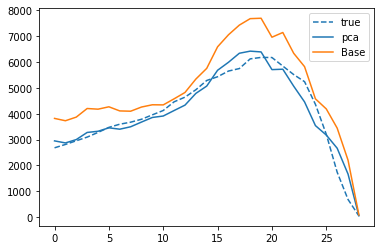

Model : KLIEP
Cross Validation process...
Parameter sigma = 0.0100 -- J-score = 0.101 (0.007)
Parameter sigma = 0.1000 -- J-score = -1.861 (1.033)
Parameter sigma = 0.5000 -- J-score = 0.103 (1.002)
Parameter sigma = 1.0000 -- J-score = 0.797 (0.039)
Parameter sigma = 2.0000 -- J-score = 0.990 (0.019)
Cross Validation process...
Parameter sigma = 0.0100 -- J-score = 0.109 (0.004)
Parameter sigma = 0.1000 -- J-score = -2.086 (0.877)
Parameter sigma = 0.5000 -- J-score = 0.649 (0.020)
Parameter sigma = 1.0000 -- J-score = 0.840 (0.061)
Parameter sigma = 2.0000 -- J-score = 0.987 (0.052)


C:\Bib\envs\statmath38\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)


Error src pca: 0.073
Error tgt pca: 0.087
Error src sum: 7.604
Error tgt sum: 2.378


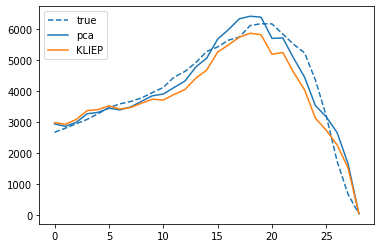

Model : KMM


C:\Bib\envs\statmath38\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)


Error src pca: 0.075
Error tgt pca: 0.083
Error src sum: 12.810
Error tgt sum: 5.551


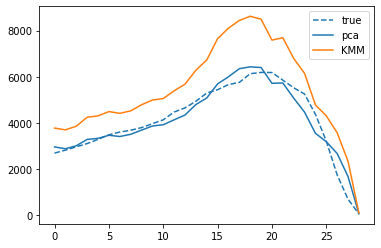

Model : CORAL
Previous covariance difference: 0.251701
New covariance difference: 0.000002


C:\Bib\envs\statmath38\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)


Error src pca: 0.104
Error tgt pca: 0.094
Error src sum: 28.517
Error tgt sum: 36.332


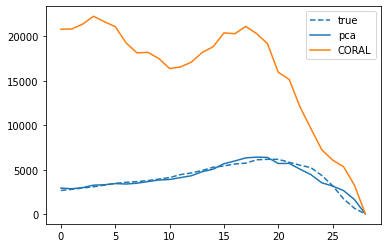

Model : DeepCORAL


C:\Bib\envs\statmath38\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)


Error src pca: 0.078
Error tgt pca: 0.084
Error src sum: 17.541
Error tgt sum: 9.138


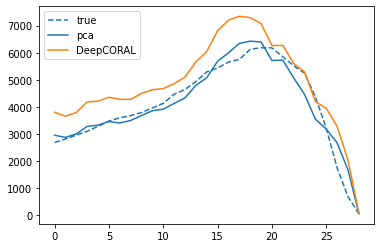

Model : DANN


C:\Bib\envs\statmath38\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)


Error src pca: 0.074
Error tgt pca: 0.085
Error src sum: 3.599
Error tgt sum: 3.192


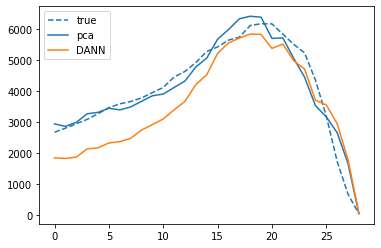

Model : MDD


C:\Bib\envs\statmath38\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)


Error src pca: 0.075
Error tgt pca: 0.085
Error src sum: 4.752
Error tgt sum: 4.835


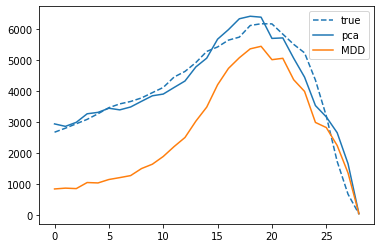

In [10]:
np.random.seed(1234)
random_states = np.random.choice(2**20, n_models, replace=False)

for k in range(n_models):
    
    print("------- Model %i --------"%k)
    
    for method in method_list:

        print("Model : %s"%method)
        
        # Set seed
        np.random.seed(random_states[k])
        tf.random.set_seed(random_states[k])
        
        # Split source set in a train and test dataset according to the custom split function
        # (the test set will be used as validation set)
        mastersplit = custom_train_test_split(y_sum[src_index], nfolds=5)
        train = mastersplit[0][0]
        test = mastersplit[0][1]
        
        # Define checkpoints to restore the weights with lowest validation error
        checkpoint_sum = ModelCheckpoint(
               filepath="weights_sum_%s.hdf5"%TARGET,
                monitor="val_loss",
                save_best_only=True,
                save_weights_only=True,
                verbose=0)
        checkpoint_pca = ModelCheckpoint(
               filepath="weights_pca_%s.hdf5"%TARGET,
                monitor="val_loss",
                save_best_only=True,
                save_weights_only=True,
                verbose=0)
        validation_data_sum = (X[src_index][test], y_sum[src_index][test])
        validation_data_pca = (X[src_index][test], y_pca[src_index][test])
            
        # Fit the model
        if method == "Base":
            model_pca = get_base_model_pca()
            model_pca.fit(X[src_index][train],
                          y_pca[src_index][train],
                          validation_data=validation_data_pca,
                          callbacks=[checkpoint_pca],
                          **fit_params_pca)

            model_sum = get_base_model_sum()
            model_sum.fit(X[src_index][train],
                          y_sum[src_index][train],
                          validation_data=validation_data_sum,
                          callbacks=[checkpoint_sum],
                          **fit_params_sum)
            
        if method == "KLIEP":
            kliep = KLIEP(sigmas=kliep_sigmas, lr=kliep_lr, max_iter=kliep_max_iter)
            weights_train = kliep.fit_weights(X[src_index][train], X[tgt_index])
            weights_test = kliep.fit_weights(X[src_index][test], X[tgt_index])
            
            model_pca = get_base_model_pca()
            model_pca.fit(X[src_index][train],
                          y_pca[src_index][train],
                          sample_weight=weights_train,
                          validation_data=validation_data_pca+(weights_test,),
                          callbacks=[checkpoint_pca],
                          **fit_params_pca)

            model_sum = get_base_model_sum()
            model_sum.fit(X[src_index][train],
                          y_sum[src_index][train],
                          sample_weight=weights_train,
                          validation_data=validation_data_sum+(weights_test,),
                          callbacks=[checkpoint_sum],
                          **fit_params_sum)
            
        if method == "KMM":
            kmm = KMM(gamma=kmm_gamma, verbose=0, max_size=kmm_max_size)
            weights_train = kmm.fit_weights(X[src_index][train], X[tgt_index])
            weights_test = kmm.fit_weights(X[src_index][test], X[tgt_index])
            
            model_pca = get_base_model_pca()
            model_pca.fit(X[src_index][train],
                          y_pca[src_index][train],
                          sample_weight=weights_train,
                          validation_data=validation_data_pca+(weights_test,),
                          callbacks=[checkpoint_pca],
                          **fit_params_pca)

            model_sum = get_base_model_sum()
            model_sum.fit(X[src_index][train],
                          y_sum[src_index][train],
                          sample_weight=weights_train,
                          validation_data=validation_data_sum+(weights_test,),
                          callbacks=[checkpoint_sum],
                          **fit_params_sum)
            
        if method == "CORAL":
            coral = CORAL(lambda_=coral_lambda)
            X_enc = coral.fit_transform(X[src_index], X[tgt_index])
            
            validation_data_sum = (X_enc[test], y_sum[src_index][test])
            validation_data_pca = (X_enc[test], y_pca[src_index][test])
            
            model_pca = get_base_model_pca()
            model_pca.fit(X_enc[train],
                          y_pca[src_index][train],
                          validation_data=validation_data_pca,
                          callbacks=[checkpoint_pca],
                          **fit_params_pca)

            model_sum = get_base_model_sum()
            model_sum.fit(X_enc[train],
                          y_sum[src_index][train],
                          validation_data=validation_data_sum,
                          callbacks=[checkpoint_sum],
                          **fit_params_sum)
             
        if method == "DANN":
            model_pca = DANN(get_encoder(),
                             get_task_pca(),
                             get_discriminator(),
                             loss=custom_loss,
                             lambda_=dann_lambda,
                             optimizer=Adam(lr_kpca))
            model_pca.fit(X[src_index][train], 
                          y_pca[src_index][train],
                          X[tgt_index],
                          validation_data=validation_data_pca,
                          callbacks=[checkpoint_pca],
                          **fit_params_pca)

            model_sum = DANN(get_encoder(),
                             get_task_sum(),
                             get_discriminator(),
                             lambda_=dann_lambda,
                             optimizer=Adam(lr_scale))
            model_sum.fit(X[src_index][train], 
                          y_sum[src_index][train],
                          X[tgt_index],
                          validation_data=validation_data_sum,
                          callbacks=[checkpoint_sum],
                          **fit_params_sum)
            
        if method == "DeepCORAL":
            model_pca = DeepCORAL(get_encoder(),
                             get_task_pca(),
                                  loss=custom_loss,
                             lambda_=deepcoral_lambda,
                             optimizer=Adam(lr_kpca))
            model_pca.fit(X[src_index][train], 
                          y_pca[src_index][train],
                          X[tgt_index],
                          validation_data=validation_data_pca,
                          callbacks=[checkpoint_pca],
                          **fit_params_pca)

            model_sum = DeepCORAL(get_encoder(),
                             get_task_sum(),
                             lambda_=deepcoral_lambda,
                             optimizer=Adam(lr_scale))
            model_sum.fit(X[src_index][train], 
                          y_sum[src_index][train],
                          X[tgt_index],
                          validation_data=validation_data_sum,
                          callbacks=[checkpoint_sum],
                          **fit_params_sum)
            
        if method == "MDD":
            model_pca = MDD(get_encoder(),
                             get_task_pca(),
                            loss=custom_loss,
                             lambda_=mdd_lambda,
                             optimizer=Adam(lr_kpca))
            model_pca.fit(X[src_index][train], 
                          y_pca[src_index][train],
                          X[tgt_index],
                          validation_data=validation_data_pca,
                          callbacks=[checkpoint_pca],
                          **fit_params_pca)

            model_sum = MDD(get_encoder(),
                             get_task_sum(),
                             lambda_=mdd_lambda,
                             optimizer=Adam(lr_scale))
            model_sum.fit(X[src_index][train], 
                          y_sum[src_index][train],
                          X[tgt_index],
                          validation_data=validation_data_sum,
                          callbacks=[checkpoint_sum],
                          **fit_params_sum)
        
        # Reload weights with lowest validation error
        model_pca.load_weights("weights_pca_%s.hdf5"%TARGET)
        model_sum.load_weights("weights_sum_%s.hdf5"%TARGET)
        
        # Compute predictions 
        yp_pca = model_pca.predict(X)
        yp_sum = model_sum.predict(X)
        yp_conv = convert_y(yp_pca, yp_sum)

        # Save predictions
        np.save("results/%s/%s_pca_%i.npy"%(TARGET, method, k), yp_pca)
        np.save("results/%s/%s_sum_%i.npy"%(TARGET, method, k), yp_sum)
        np.save("results/%s/%s_conv_%i.npy"%(TARGET, method, k), yp_conv)
            
        # Compute Error on kpca and scale predictions
        print("Error src pca: %.3f"%mean_absolute_error(yp_pca[src_index], y_pca[src_index]))
        print("Error tgt pca: %.3f"%mean_absolute_error(yp_pca[tgt_index], y_pca[tgt_index]))
        print("Error src sum: %.3f"%mean_absolute_error(yp_sum[src_index], y_sum[src_index]))
        print("Error tgt sum: %.3f"%mean_absolute_error(yp_sum[tgt_index], y_sum[tgt_index]))
        
        # Plot the predctions of the sum of star formation history
        plt.plot(y_true[tgt_index].sum(0), label="true", c="C0", ls="--")
        plt.plot(y_conv[tgt_index].sum(0), label="pca")
        plt.plot(yp_conv[tgt_index].sum(0), label=method)
        plt.legend()
        plt.show()